## Remove the eclipsing binary from the full signal

- Use Celerite2
- Eclipsing binary + Pulsation + noise
- Matern32 kernel

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Use Celerite v2
import celerite2
from celerite2 import terms

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilCelerite()

# Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
df = pd.read_csv("./simulations/sim_010_sc.dat",sep=' ', header = None, names=['Time', 'LC', 'N'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
LC      float64
N       float64
dtype: object

In [4]:
X, Y, N = df['Time'].tolist(), df['LC'].tolist(), df['N'].tolist()
X, Y, N = np.array(X), np.array(Y), np.array(N)
Y = Y+N

# 1. Exploratory
Plot the data

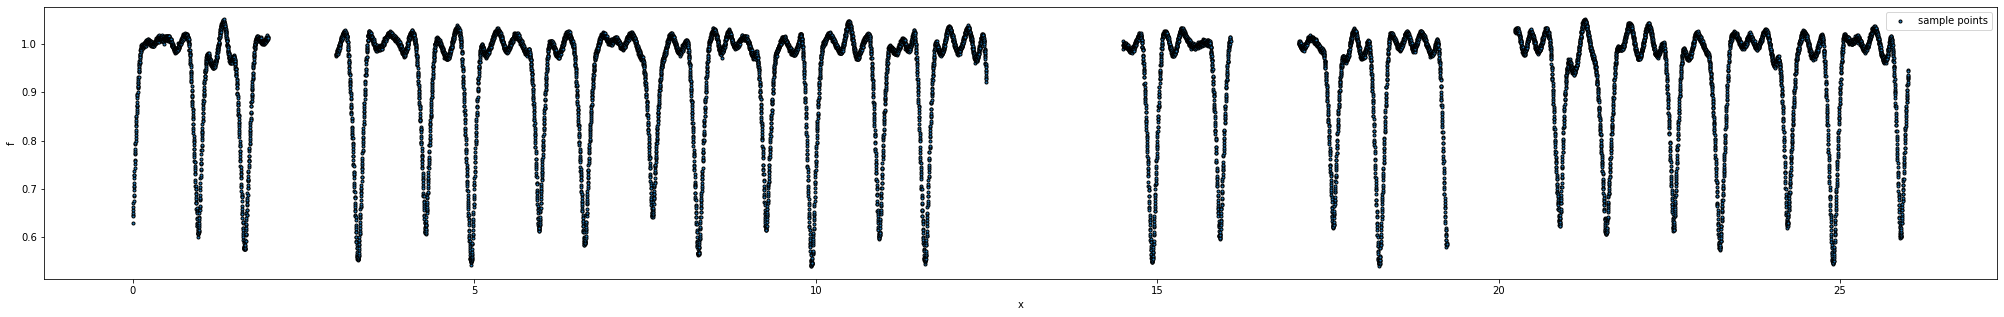

In [5]:
plotter.plot_data(X, Y)

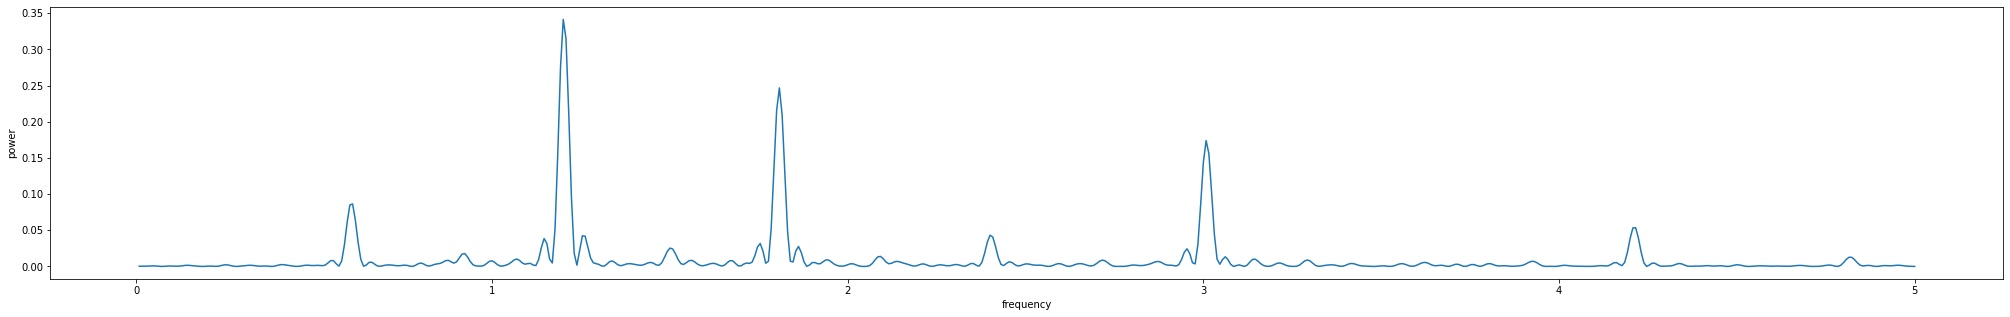

In [6]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)

Zoomed in on the first N observations

In [7]:
N_part=11300

In [8]:
X_part=X[:N_part]
Y_part=Y[:N_part]

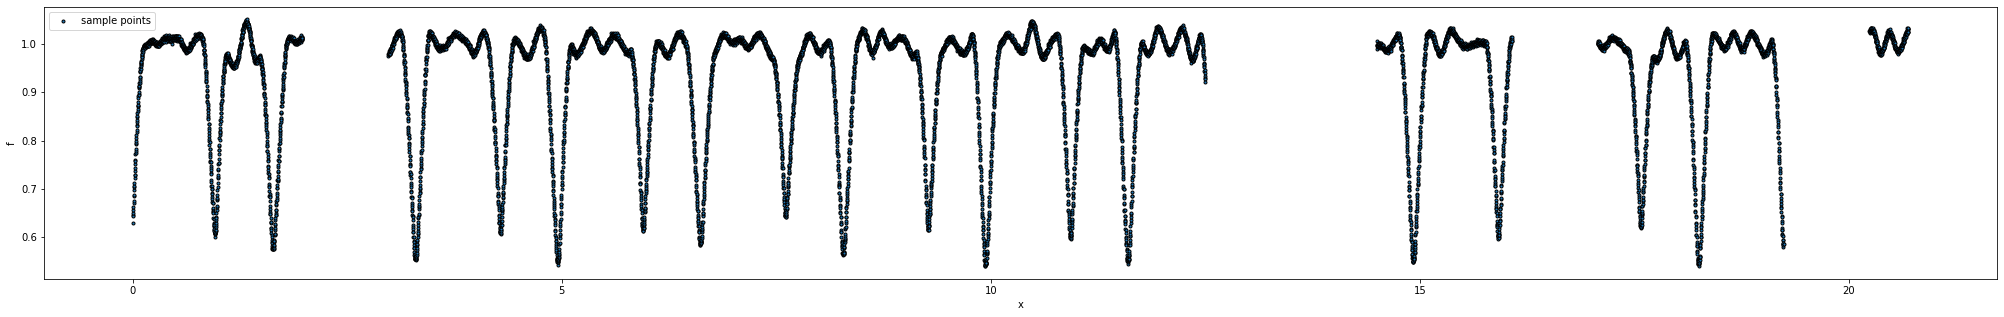

In [9]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [10]:
# normalize the data
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

In [11]:
plotter.plot_data(X_part, Y_part)

In [12]:
# Matern 3/2 term
kernel = terms.Matern32Term(sigma=1.0, rho=1.0, eps=10.0)

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(X_part, yerr=0)

print("Initial log likelihood: {0}".format(gp.log_likelihood(Y_part)))

Initial log likelihood: -22007016.221355386


In [13]:
from scipy.optimize import minimize

yerr=1

def set_params(params, gp, t):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.Matern32Term(sigma=theta[0], rho=theta[1], eps=theta[2])
    gp.compute(t, diag=yerr ** 2 + theta[3], quiet=True)
    return gp

def neg_log_like(params, gp, t, y):
    gp = set_params(params, gp, t)
    return -gp.log_likelihood(y)

# [mean, sigma1, rho1, tau1, sigma2, rho2, ]
# Q2=0.25
initial_params = [0.0, 0.0, 0.0, np.log(10.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,X_part, Y_part))
gp = set_params(soln.x, gp, X_part)
soln

      fun: 10882.370603612688
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.09313226,  0.01491571, -0.03728928, -0.02764864,  0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 222
      nit: 29
     njev: 37
   status: 0
  success: True
        x: array([-1.38953416e-02,  6.09590213e-04, -8.32462715e-01,  2.63245847e+00,
       -1.69680621e+01])

In [14]:
# We now use Celerite to predict the missing data on the training data scope
Y_part_pred, Y_part_pred_var = gp.predict(Y_part, t=X_part, return_var=True)

In [16]:
gp.predict(Y_part, t=X_part, return_var=True)

(array([-2.02669866, -2.00714862, -1.98657698, ...,  0.68908235,
         0.68774068,  0.68613262]),
 array([0.06019331, 0.05657619, 0.053194  , ..., 0.053194  , 0.05657619,
        0.06019331]))

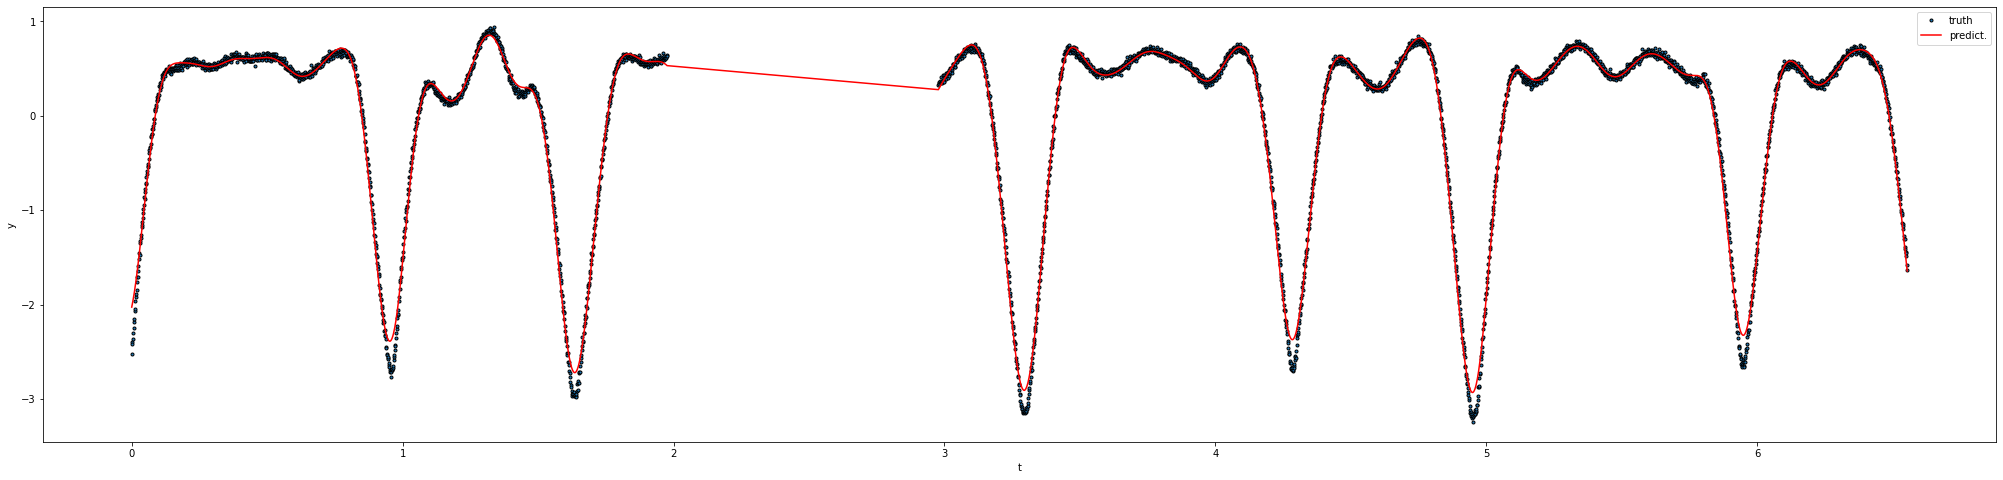

In [17]:
# Plot series with the original X positions
plotter.plot_series(X_part[:4000], Y_part[:4000], X_part[:4000], Y_part_pred[:4000])

In [18]:
# Calculate the residuals on the original X positions!
residuals = Y_part-Y_part_pred

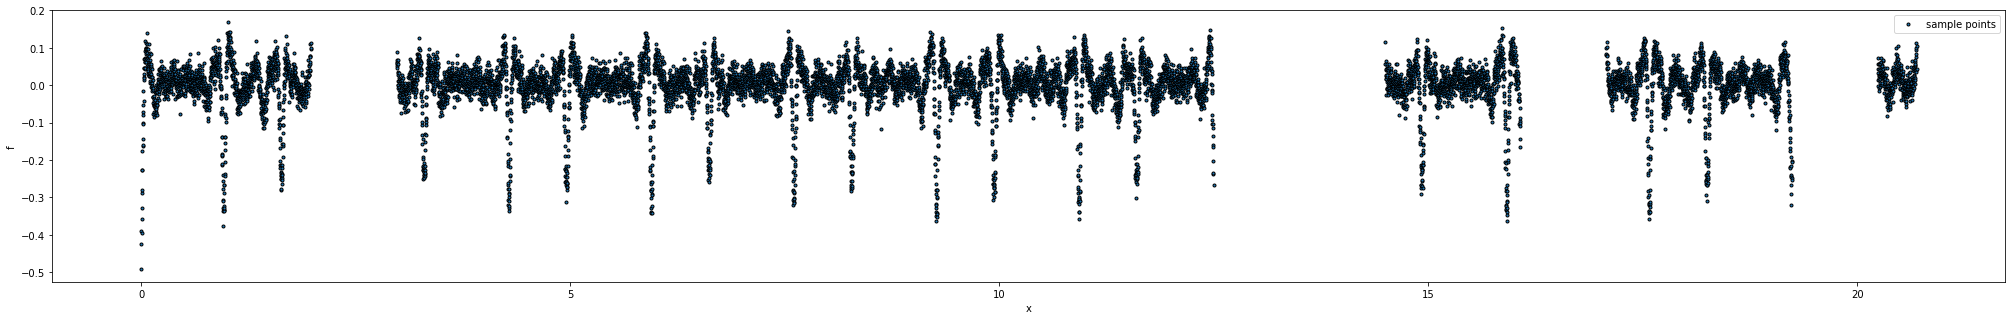

In [19]:
# Plot GP residuals
plotter.plot_data(X_part, residuals)

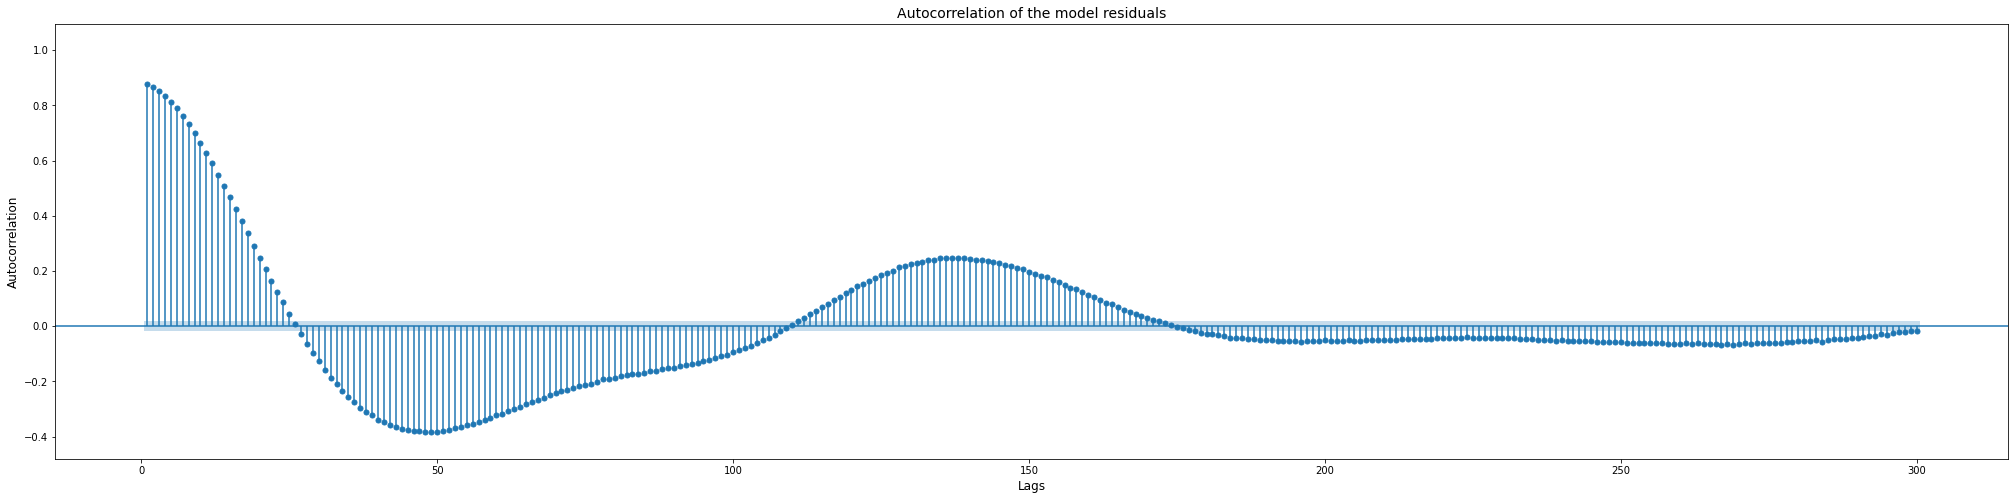

In [20]:
# Now plot the ACF of the residuals. Amplitudes should be under 0.05.
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(35, 8))
# Plot ACF of JPM stock prices for past 40 lags
plot_acf(residuals, lags=300, alpha=1-0.95, zero=False, auto_ylims=True, bartlett_confint=False)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of the model residuals', fontsize=14)
plt.show()

In [21]:
# The confidence interval in the plot is calculated as:
# qnorm((1 + ci)/2)/sqrt(N)
# Our CI is 0.95

# Correlation between the pulsation+noise data and the full data with E.B. removed

In [22]:
df = pd.read_csv("./data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
X_orig_pulse, Y_orig_pulse = df['Time'].tolist(), df['Lc'].tolist()
X_orig_pulse, Y_orig_pulse = np.array(X_orig_pulse), np.array(Y_orig_pulse)
X_orig_pulse = X_orig_pulse[:N_part]
Y_orig_pulse = Y_orig_pulse[:N_part]

In [23]:
# normalize the data, using the same formula as for the full signal!
_, _, Y_orig_pulse = experiment_util.normalize_mean(Y_orig_pulse)

In [24]:
experiment_util.calculate_error(Y_orig_pulse, Y_part_pred)

TimeSeriesSimilarity(correlation=0.01477537061596876, rmse=1.387618356642975)

In [25]:
# Now plot our processed lightcurve over the artificial pulse only lightcurve. They should be the same!
plotter.plot_series(X_orig_pulse, Y_orig_pulse, X_part, Y_part_pred)

In [26]:
# 4000 data points
# Trial 1: 0.9993879075302063 correlation, 50 iterations, length scale: 0.20819413760826516
# Trial 2: 0.9996495773845258 correlation, 100 iterations, length scale: 0.18682588807289266

# 12000 data points
# Trial 1: 0.9996183045048753 correlation, 50 iterations, length scale: 0.11315121991279563
# Trial 2: 0.9996493196737065 correlation, 100 iterations, length scale: 0.09515259122517888

# Conclusion:
#    100 iterations results in a slightly higher correlation
#    TODO: Compare two timeseries visually, my guess is that on the one with 50 iterations does not reach the crests and throughs of the sine waves.